In [1]:
import pickle
import pandas as pd
import os
from explainers.dce import DistributionalCounterfactualExplainer
import torch
from utils.visualization import *
from utils.data_processing import *
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
DEBUG:root:test


In [4]:
data_path = 'data/german_credit'

In [6]:
df_ = pd.read_csv(os.path.join(data_path, 'german_credit_data.csv'))
df = df_.copy()

In [7]:
df.sample(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
480,23,female,1,own,little,moderate,3573,12,radio/TV,good
349,32,male,2,free,rich,moderate,1136,9,education,bad
839,46,male,2,own,little,NaN,2611,24,radio/TV,good
115,47,male,2,own,NaN,NaN,3578,48,radio/TV,good
633,19,female,2,rent,little,NaN,1980,9,furniture/equipment,bad


In [8]:
df, label_mappings = feature_encoding(df=df, target_name='Risk', target_encode_dict={"good": 0, "bad": 1})

In [198]:
factual = pd.read_csv(os.path.join(data_path,'factual.csv'))
counterfactual = pd.read_csv(os.path.join(data_path,'counterfactual.csv'))

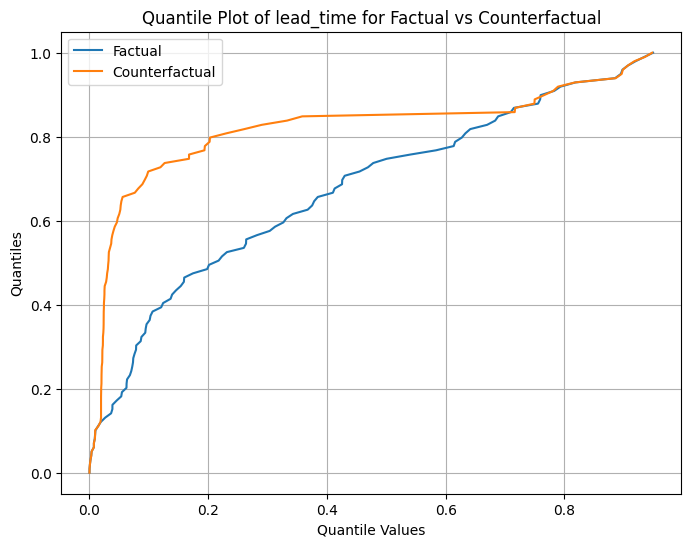

In [199]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Risk');

In [200]:
factual

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,39,male,2,own,little,Unknown,1473,18,radio/TV,0.072231
1,54,male,2,own,little,little,3051,48,domestic appliances,0.919690
2,27,male,2,own,quite rich,moderate,2326,15,business,0.062517
3,40,male,1,own,little,moderate,1155,12,radio/TV,0.086446
4,36,male,2,own,Unknown,Unknown,3079,36,car,0.153896
...,...,...,...,...,...,...,...,...,...,...
95,30,male,3,own,little,moderate,5965,27,car,0.410081
96,44,male,2,own,quite rich,Unknown,1163,12,car,0.001928
97,29,female,2,rent,rich,moderate,7758,24,car,0.101598
98,37,female,2,rent,little,little,7685,48,business,0.907074


In [201]:
counterfactual

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,39,male,2,own,little,Unknown,1442,17,radio/TV,0.024060
1,54,male,2,own,little,little,3029,48,domestic appliances,0.917797
2,27,male,2,own,quite rich,moderate,2586,14,business,0.036830
3,40,male,1,own,little,moderate,1385,10,radio/TV,0.047721
4,36,male,2,own,Unknown,Unknown,3169,36,car,0.021801
...,...,...,...,...,...,...,...,...,...,...
95,29,male,3,own,little,moderate,5126,26,car,0.167848
96,44,male,2,own,quite rich,Unknown,1169,12,car,0.001874
97,29,female,2,rent,rich,moderate,7636,22,car,0.034854
98,37,female,2,rent,little,little,7654,48,business,0.906850


In [202]:
interval = (0, 25, 35, 65, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

for cat in cats:
    risk_prob = df[df.Age_cat == cat]['Risk'].mean()
    print(f'Risk {cat}: {risk_prob}')

Risk Student: 0.42105263157894735
Risk Young: 0.2964824120603015
Risk Adult: 0.24619289340101522
Risk Senior: 0.2777777777777778


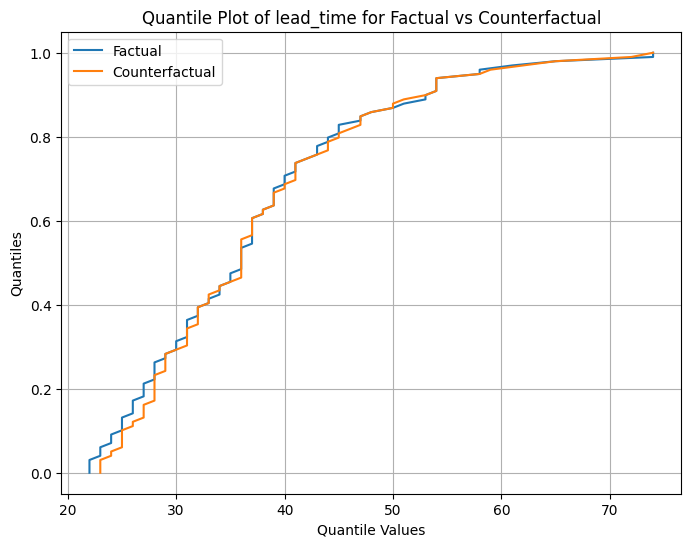

In [203]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Age');

In [204]:
factual['Risk'].mean(), counterfactual['Risk'].mean()

(0.3130257116629, 0.17500146086469998)

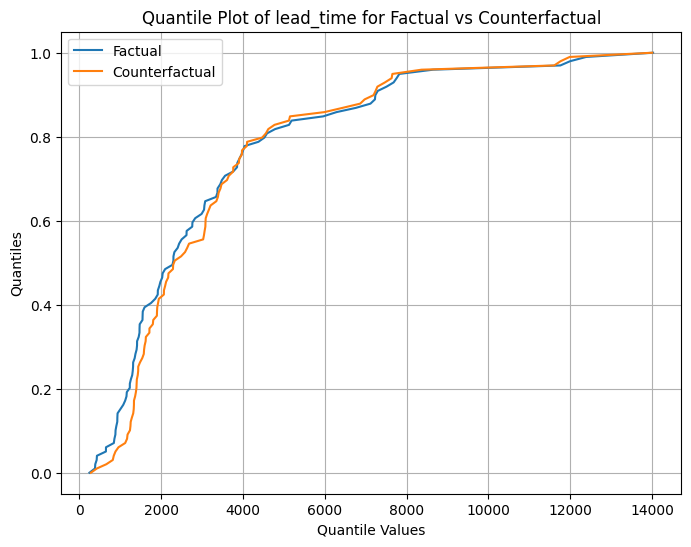

In [205]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Credit amount');

In [206]:
print('Risk Low credit amount:', df[df['Credit amount']<2000]['Risk'].mean())
print('Risk Middle credit amount:', df[ (df['Credit amount']>=2000) & (df['Credit amount']<=6000) ]['Risk'].mean())
print('Risk High credit amount:', df[df['Credit amount']>6000]['Risk'].mean())

Risk Low credit amount: 0.2800925925925926
Risk Middle credit amount: 0.2649164677804296
Risk High credit amount: 0.4563758389261745


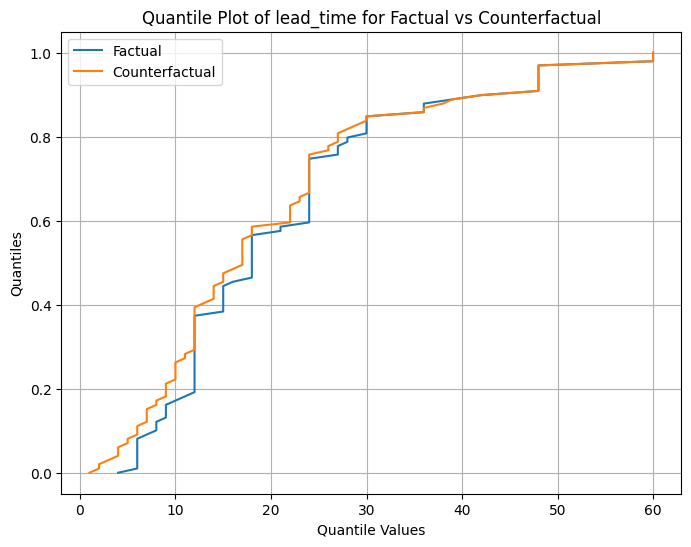

In [207]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Duration');

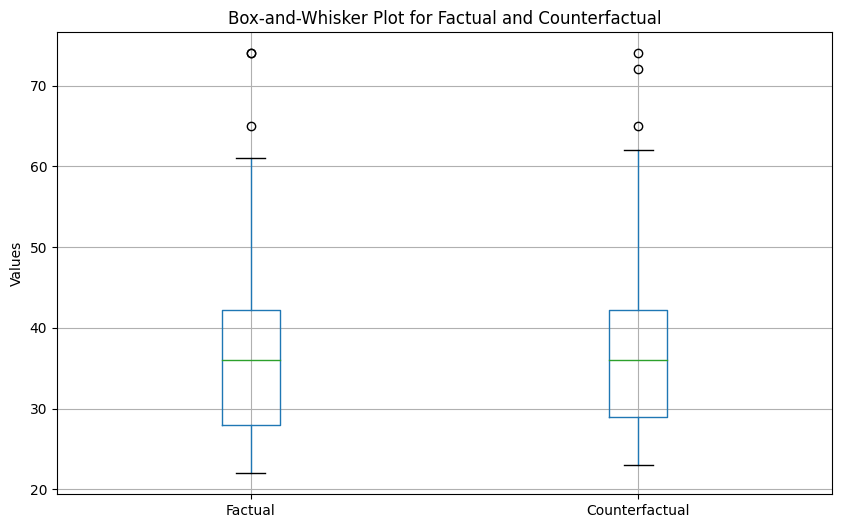

In [208]:
plot_box_whisker(factual=factual, counterfactual=counterfactual, column_name='Age')

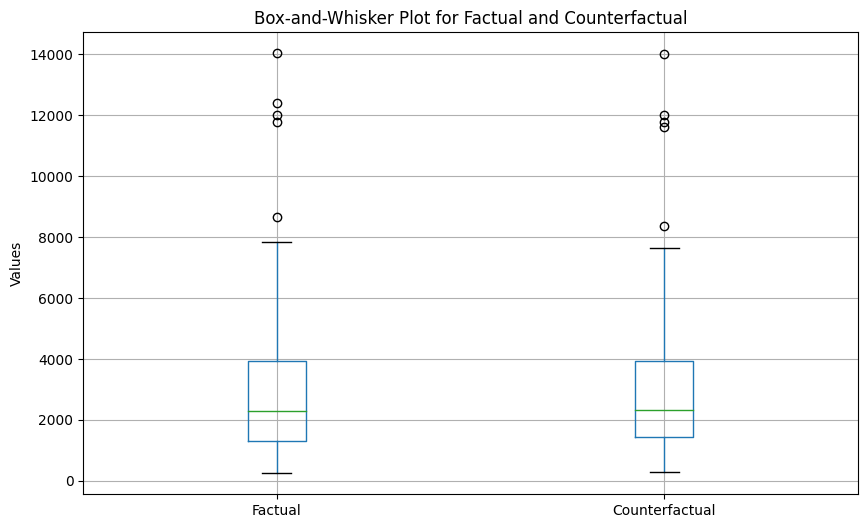

In [209]:
plot_box_whisker(factual=factual, counterfactual=counterfactual, column_name='Credit amount')

In [210]:
factual

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,39,male,2,own,little,Unknown,1473,18,radio/TV,0.072231
1,54,male,2,own,little,little,3051,48,domestic appliances,0.919690
2,27,male,2,own,quite rich,moderate,2326,15,business,0.062517
3,40,male,1,own,little,moderate,1155,12,radio/TV,0.086446
4,36,male,2,own,Unknown,Unknown,3079,36,car,0.153896
...,...,...,...,...,...,...,...,...,...,...
95,30,male,3,own,little,moderate,5965,27,car,0.410081
96,44,male,2,own,quite rich,Unknown,1163,12,car,0.001928
97,29,female,2,rent,rich,moderate,7758,24,car,0.101598
98,37,female,2,rent,little,little,7685,48,business,0.907074


In [211]:
counterfactual

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,39,male,2,own,little,Unknown,1442,17,radio/TV,0.024060
1,54,male,2,own,little,little,3029,48,domestic appliances,0.917797
2,27,male,2,own,quite rich,moderate,2586,14,business,0.036830
3,40,male,1,own,little,moderate,1385,10,radio/TV,0.047721
4,36,male,2,own,Unknown,Unknown,3169,36,car,0.021801
...,...,...,...,...,...,...,...,...,...,...
95,29,male,3,own,little,moderate,5126,26,car,0.167848
96,44,male,2,own,quite rich,Unknown,1169,12,car,0.001874
97,29,female,2,rent,rich,moderate,7636,22,car,0.034854
98,37,female,2,rent,little,little,7654,48,business,0.906850


In [212]:
factual['Risk_state'] = factual['Risk'] > 0.5
counterfactual['Risk_state'] = counterfactual['Risk'] > 0.5

factual['Risk_state'] = factual['Risk_state'].replace({True: 'bad', False: 'good'})
counterfactual['Risk_state'] = counterfactual['Risk_state'].replace({True: 'bad', False: 'good'})

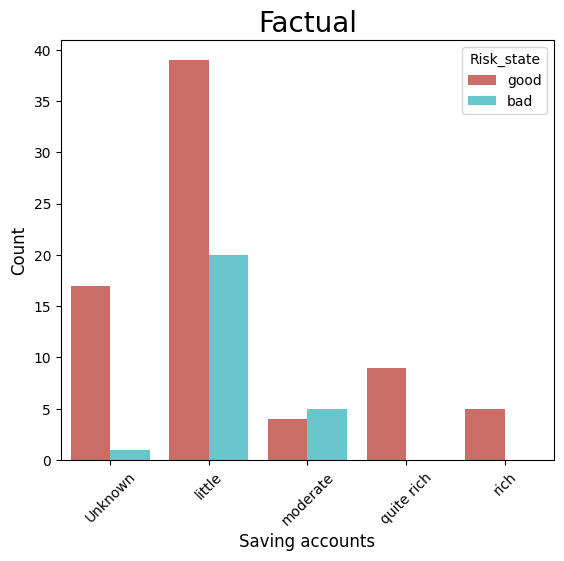

In [213]:
hist_plot(df=factual, x="Saving accounts", hue="Risk_state", title="Factual")

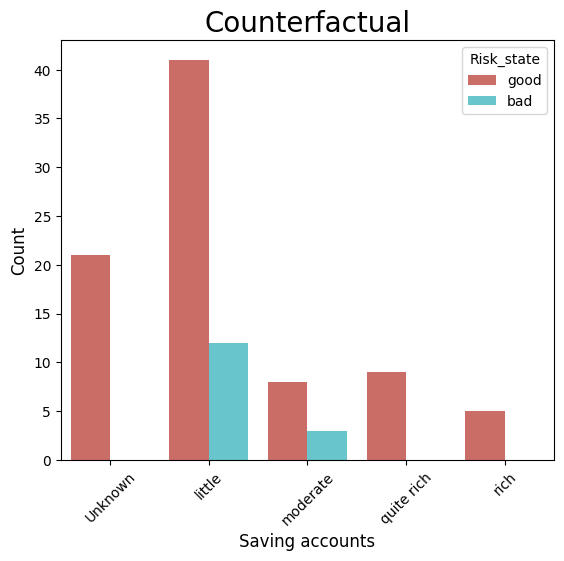

In [214]:
hist_plot(df=counterfactual, x="Saving accounts", hue="Risk_state", title="Counterfactual")

In [215]:
factual_little = factual[factual['Saving accounts'] == 'little']
counterfactual_little = counterfactual[counterfactual['Saving accounts'] == 'little']

In [216]:
factual_little['Risk'].mean(), counterfactual_little['Risk'].mean()

(0.39519174937288143, 0.24830888967924528)

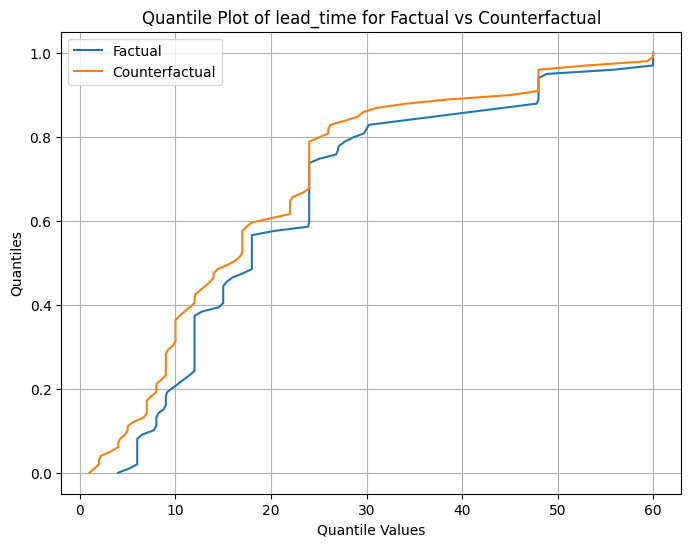

In [217]:
plot_quantile(factual=factual_little, counterfactual=counterfactual_little, column_name='Duration');

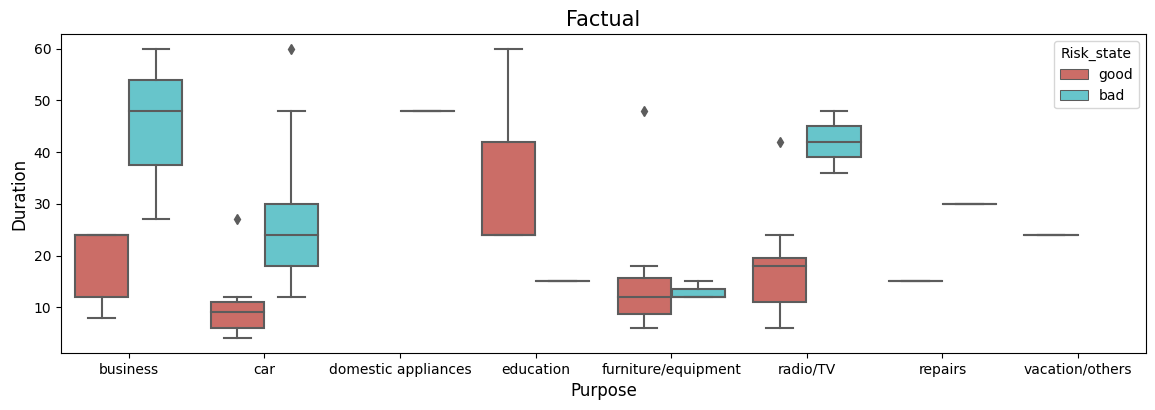

In [218]:
category_box_plot(df=factual_little, x="Purpose", y="Duration", hue="Risk_state", title="Factual")

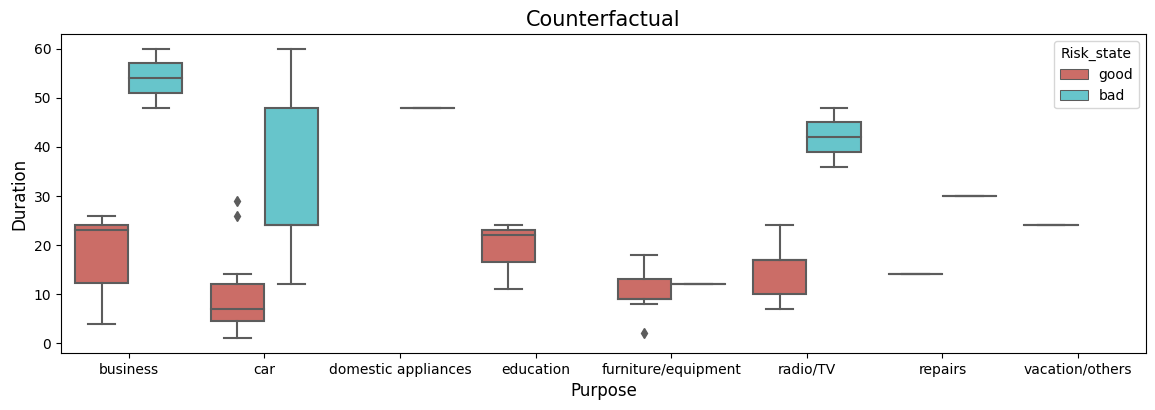

In [219]:
category_box_plot(df=counterfactual_little, x="Purpose", y="Duration", hue="Risk_state", title="Counterfactual")

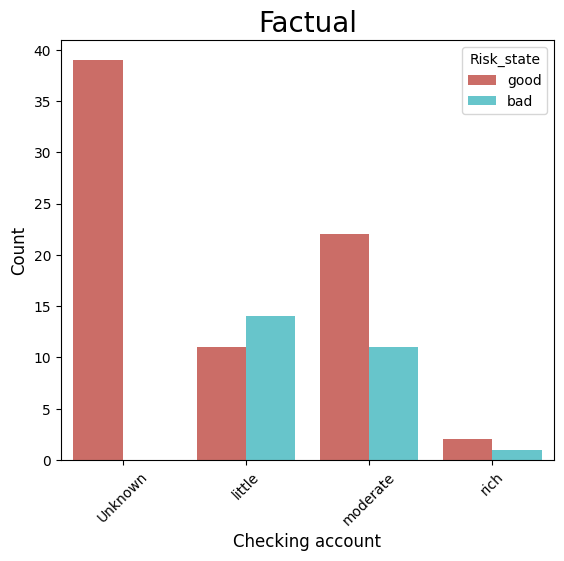

In [220]:
hist_plot(df=factual, x="Checking account", hue="Risk_state", title="Factual")

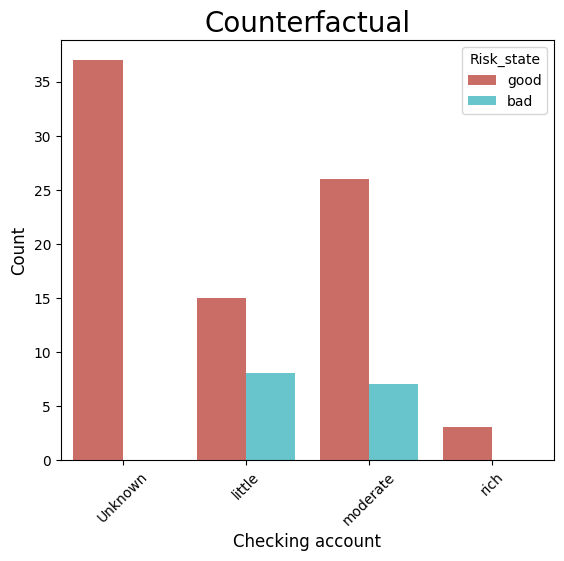

In [221]:
hist_plot(df=counterfactual, x="Checking account", hue="Risk_state", title="Counterfactual")

In [222]:
factual_check_moderate = factual[factual['Checking account']=='moderate']
counterfactual_check_moderate = counterfactual[counterfactual['Checking account']=='moderate']

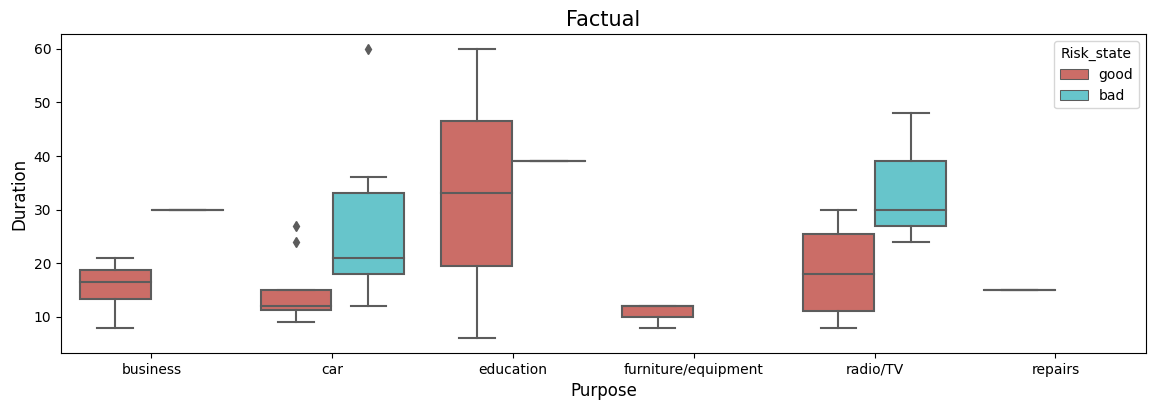

In [223]:
category_box_plot(df=factual_check_moderate, x="Purpose", y="Duration", hue="Risk_state", title="Factual")

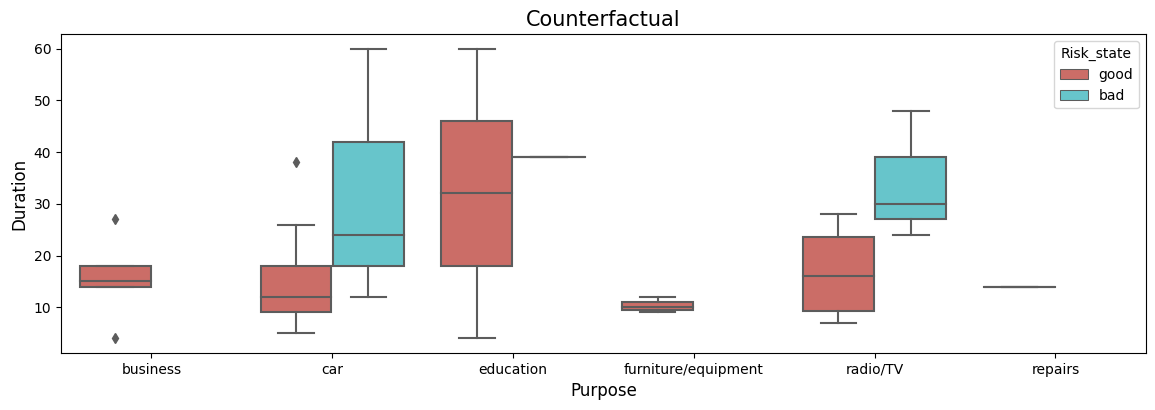

In [224]:
category_box_plot(df=counterfactual_check_moderate, x="Purpose", y="Duration", hue="Risk_state", title="Counterfactual")

In [225]:
factual['Risk'].mean()

0.3130257116629

In [226]:
counterfactual['Risk'].mean()

0.17500146086469998

In [227]:
with open(os.path.join(data_path, 'explainer.pkl'), 'rb') as file:
    explainer = pickle.load(file)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000244BE6E5FD0>


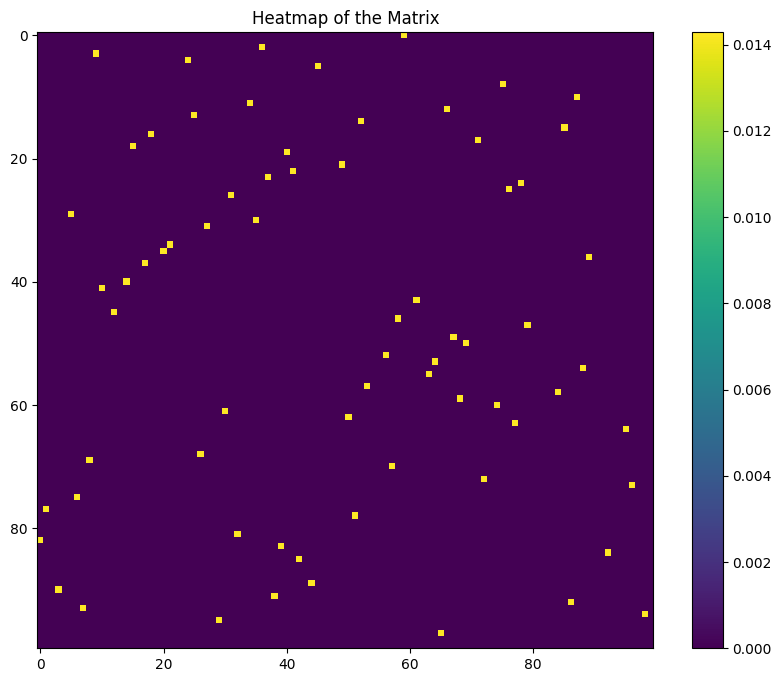

In [228]:
# Sample matrix for demonstration
matrix = explainer.wd.nu.detach().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()


In [229]:
col_names = []
col_scores = []
for column, col_index in zip(explainer.explain_columns, explainer.explain_indices):

    y_s = torch.FloatTensor(explainer.X[:, col_index])
    y_t = torch.FloatTensor(explainer.X_prime[:, col_index])
    wd_dist, _ = explainer.wd.distance(y_s, y_t, delta=0)

    col_names.append(column)
    col_scores.append(wd_dist.item())

pd.DataFrame({
    'Feature': col_names,
    'Score': col_scores,
}).sort_values(by='Score', ascending=False)

,Feature,Score
4,Saving accounts,0.068774
5,Checking account,0.060398
7,Duration,0.018836
3,Housing,0.010426
8,Purpose,0.010098
1,Sex,0.008110
6,Credit amount,0.007604
2,Job,0.007195
0,Age,0.004521


In [232]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factual.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

ValueError: could not convert string to float: 'male'

<Figure size 1600x600 with 0 Axes>

In [138]:
explainer.explain_columns

['Age',
 'Sex',
 'Job',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Credit amount',
 'Duration',
 'Purpose']

In [135]:
explainer.explain_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8]

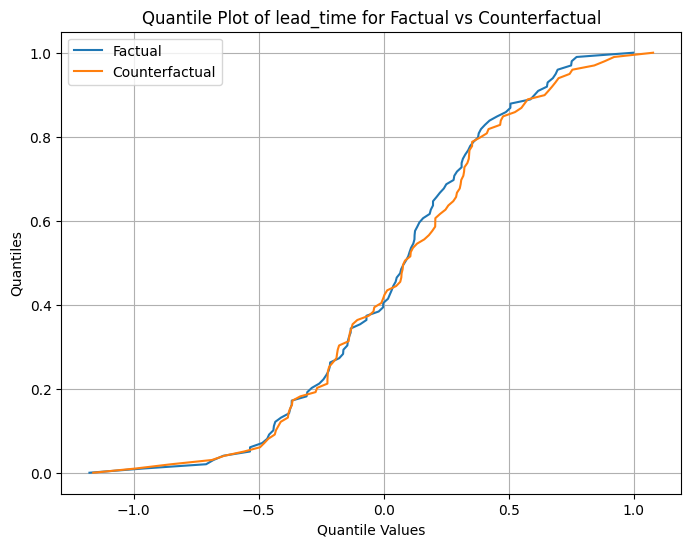

In [132]:

fa = torch.zeros_like(explainer.X_prime[:, explainer.explain_indices] @ explainer.swd.thetas[0])
dfa = torch.zeros_like(explainer.X_prime[:, explainer.explain_indices] @ explainer.swd.thetas[0])
for theta in explainer.swd.thetas:

    fa += explainer.X_prime[:, explainer.explain_indices] @ theta
    dfa += explainer.best_X[:, explainer.explain_indices] @ theta
    
fa /= len(explainer.swd.thetas)
dfa /= len(explainer.swd.thetas)

plot_quantile(factual=pd.DataFrame({'X': fa}), counterfactual=pd.DataFrame({'X': dfa}), column_name='X')